In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
"""
https://github.com/inmcm/present_cipher/tree/master/python
"""
# coding: utf-8
from __future__ import print_function

s_box = (0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2)

inv_s_box = (0x5, 0xE, 0xF, 0x8, 0xC, 0x1, 0x2, 0xD, 0xB, 0x4, 0x6, 0x3, 0x0, 0x7, 0x9, 0xA)

p_layer_order = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51, 4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38,
                 54, 7, 23, 39, 55, 8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59, 12, 28, 44, 60, 13,
                 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]

block_size = 64

ROUND_LIMIT = 32


def round_function(state, key):
    new_state = state ^ key
    state_nibs = []
    for x in range(0, block_size, 4):
        nib = (new_state >> x) & 0xF
        sb_nib = s_box[nib]
        state_nibs.append(sb_nib)
    # print(state_nibs)

    state_bits = []
    for y in state_nibs:
        nib_bits = [1 if t == '1'else 0 for t in format(y, '04b')[::-1]]
        state_bits += nib_bits
    # print(state_bits)
    # print(len(state_bits))

    state_p_layer = [0 for _ in range(64)]
    for p_index, std_bits in enumerate(state_bits):
        state_p_layer[p_layer_order[p_index]] = std_bits

    # print(len(state_p_layer), state_p_layer)

    round_output = 0
    for index, ind_bit in enumerate(state_p_layer):
        round_output += (ind_bit << index)

    # print(format(round_output, '#016X'))

    # print('')
    return round_output


def key_function_80(key, round_count):
    # print('Start: ', hex(key))
    # print('')

    r = [1 if t == '1'else 0 for t in format(key, '080b')[::-1]]

    # print('k bits:', r)
    # print('')

    h = r[-61:] + r[:-61]

    # print('s bits:', h)
    # print('')

    round_key_int = 0
    # print('init round int:', hex(round_key_int))
    for index, ind_bit in enumerate(h):
        round_key_int += (ind_bit << index)
        # print('round:',index, '-', hex(round_key_int))

    # print('round_key_int', hex(round_key_int))
    # print('')

    upper_nibble = round_key_int >> 76

    # print('upper_nibble:', upper_nibble)

    upper_nibble = s_box[upper_nibble]

    # print('upper_nibble sboxed', hex(upper_nibble))

    xor_portion = ((round_key_int >> 15) & 0x1F) ^ round_count
    # print('Count:', round_count)
    # print('XOR Value:', xor_portion)

    # print('Before:', hex(round_key_int))
    round_key_int = (round_key_int & 0x0FFFFFFFFFFFFFF07FFF) + (upper_nibble << 76) + (xor_portion << 15)
    # print('After: ', hex(round_key_int))

    return round_key_int



test_vectors_80 = {1:(0x00000000000000000000, 0x0000000000000000, 0x5579C1387B228445),
                2:(0xFFFFFFFFFFFFFFFFFFFF, 0x0000000000000000, 0xE72C46C0F5945049),
                3:(0x00000000000000000000, 0xFFFFFFFFFFFFFFFF, 0xA112FFC72F68417B),
                4:(0xFFFFFFFFFFFFFFFFFFFF, 0xFFFFFFFFFFFFFFFF, 0x3333DCD3213210D2)}
        
def PRESENT(P, K, ROUND):
    key_schedule = []
    current_round_key = K
    round_state = P
    
    if(ROUND==0):
        return P

    for rnd_cnt in range(ROUND):
        key_schedule.append(current_round_key >> 16)
        current_round_key = key_function_80(current_round_key, rnd_cnt + 1)

    for rnd in range(ROUND - 1):
        round_state = round_function(round_state, key_schedule[rnd])

    round_state ^= key_schedule[ROUND-1]
    
    return round_state

In [3]:
Wang_diff = [0x7000000000007000, 0x0700000000000700, 0x0070000000000070, 0x0007000000000007]
BLOCK_SIZE = 64
sample_num = 10000

In [4]:
def gen(sample_num, ROUND):
    P_set = []
    K_set = []
    for i in range(sample_num):
        P_set.append(random.randrange(0,2**64))
        #print("%x" % P_set[i])
        K_set.append(random.randrange(0,2**80))
        #print("%x" % K_set[i])

    C_diff_set = []
    C_diff_label = []
    for i in range(sample_num):
        P = P_set[i]
        K = K_set[i]
        C = PRESENT(P, K, ROUND)
        for j in range(4):
            Cj = PRESENT(P^Wang_diff[j], K, ROUND)
            C_diff = C^Cj
            #print(C_diff)
            C_diff_set.append(C_diff)
            temp = [0, 0, 0, 0]
            temp[j] = 1
            C_diff_label.append(temp)

    tr_X = []
    for C_diff in C_diff_set:
        A = []
        for j in range(BLOCK_SIZE):
            A.append((C_diff>>j)&1)
        tr_X.append(A)
        #print(A)
    tr_X = np.array(tr_X)

    tr_X = []
    for C_diff in C_diff_set:
        A = []
        for j in range(BLOCK_SIZE):
            A.append((C_diff>>j)&1)
        tr_X.append(A)
        #print(A)
    tr_X = np.array(tr_X)
    tr_t = np.array(C_diff_label)

    ind = np.arange(len(tr_X))
    np.random.shuffle(ind)
    tr_X = tr_X[ind]
    tr_t = tr_t[ind]
    
    return tr_X, tr_t

In [5]:
def gen_random(sample_num):
    np.random.seed(0)
    Dataset = []
    Label = []
    for i in range(sample_num):
        data = random.randrange(0,2**64)
        A = []
        for j in range(BLOCK_SIZE):
            A.append((data>>j)&1)
        Dataset.append(A)
        
        temp = [0, 0, 0, 0]
        temp[random.randrange(0,4)] = 1
        Label.append(temp)
        
    Dataset = np.array(Dataset)
    Label = np.array(Label)
    
    return Dataset, Label

In [6]:
def sample_gen():
    SAMPLE_NUM_RANGE = [10000, 50000, 100000]
    ROUND_RANGE = [3, 4, 5, 6, 7, 8]
    for sn in SAMPLE_NUM_RANGE:
        for rn in ROUND_RANGE:
            tr_X, tr_t = gen(sn, rn)
            np.save("ROUND %d SAMPLE %d Dataset" % (rn, sn), tr_X)
            np.save("ROUND %d SAMPLE %d Label" % (rn, sn), tr_t)

def test_sample_gen():
    TEST_SMAPLE_NUM = 10000
    for rn in ROUND_RANGE:
        te_X, te_t = gen(TEST_SMAPLE_NUM, rn)
        np.save("ROUND %d TEST_SAMPLE Dataset" % (rn), te_X)
        np.save("ROUND %d TEST_SAMPLE Label" % (rn), te_t)
        
def load_sample(SAMPLE_NUM, ROUND_NUM):
    tr_X = np.load("ROUND %d SAMPLE %d Dataset.npy" % (ROUND_NUM, SAMPLE_NUM))
    tr_t = np.load("ROUND %d SAMPLE %d Label.npy" % (ROUND_NUM, SAMPLE_NUM))
    return tr_X, tr_t

def load_test_sample(ROUND_NUM):
    te_X = np.load("ROUND %d TEST_SAMPLE Dataset.npy" % (ROUND_NUM))
    te_t = np.load("ROUND %d TEST_SAMPLE Label.npy" % (ROUND_NUM))
    return te_X, te_t

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class MLP:
    def __init__(self, layer1=128, layer2=1028, layer3=None, reg=None, learning_rate=0.001):
        self.layers = self._build_layers(layer1, layer2, layer3, reg)
        self.model = tf.keras.Sequential(self.layers) 
        self.model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    def _build_layers(self, layer1, layer2, layer3, reg):
        if layer3==None:
            layers = [
                tf.keras.layers.Flatten(input_shape=(64,)),
                tf.keras.layers.Dense(layer1, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer2, activation='relu', kernel_regularizer=reg),
                #tf.keras.layers.Dense(layer3, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(4, activation='softmax')
            ]
        else:
            layers = [
                tf.keras.layers.Flatten(input_shape=(64,)),
                tf.keras.layers.Dense(layer1, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer2, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer3, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(4, activation='softmax')
            ]
        return layers

    #그냥 cross entropy를 그대로 정의함
    def _my_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32) #float32 => int32로 casting #None, 1
        y_true = tf.squeeze(tf.one_hot(y_true, depth=10, dtype=tf.float32), 1) # one_hot encoding #None, 1, 10 #quezze => 1을 없애줌 => None, 10
        y_pred = tf.nn.softmax(y_pred, 1) # 한 축에 대해 softmax를 적용해라 #1 => 열을 의미 #즉, 한 행에 있는 값을 다 더하면 1이 되도록 만들어줌

        #cross entropy 그대로 적용
        #-sum t*log y 한 후에 평균 냄
        return -tf.reduce_mean(tf.reduce_sum(
                tf.multiply(y_true, tf.math.log(y_pred)), 1))

    def _my_accuracy(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(tf.one_hot(y_true, depth=10, dtype=tf.float32), 1)
        #argmax를 그대로 이용
        return tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1)), tf.float32))

    def fit(self, x, t, epochs, batch_size=None, validation_split=0.0, verbose=1, shuffle=True, workers=2):
        return self.model.fit(x, t, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose, shuffle=shuffle, workers=workers)
    
    def evaluate(self, x=None, y=None, verbose=0):
        return self.model.evaluate(x=x, y=y, verbose=verbose)
    
    def summary(self):
        self.model.summary()
    
    def predict(self, x):
        return self.model.predict(x)

In [8]:
#Config
ROUND = 5
SAMPLE_NUM = 10000
ITERATION = 5

#Fix
batch_size = 200
epoch_size = 25
validation_split = 0.3 #no meaning, but to make it same with base paper

weight_L1 = 0.000204
layer1 = 128
layer2 = 512
reg = tf.keras.regularizers.L1(weight_L1)
learning_rate = 0.0037

#parameter
verbose = 1

In [9]:
tr_X, tr_t = load_sample(SAMPLE_NUM=SAMPLE_NUM, ROUND_NUM=ROUND)
te_X, te_t = load_test_sample(ROUND_NUM=ROUND)

In [10]:
model = MLP(layer1=layer1, layer2=layer2, reg = reg, learning_rate=learning_rate)
results = model.fit(tr_X, tr_t, epochs=epoch_size, batch_size=batch_size, validation_split = validation_split, shuffle=True, verbose=verbose)

Epoch 1/25
140/140 [==============================] - 0s 3ms/step - loss: 1.5816 - accuracy: 0.3624 - val_loss: 1.3862 - val_accuracy: 0.3776
Epoch 2/25
140/140 [==============================] - 0s 2ms/step - loss: 1.3303 - accuracy: 0.3929 - val_loss: 1.3120 - val_accuracy: 0.3902
Epoch 3/25
140/140 [==============================] - 0s 2ms/step - loss: 1.2786 - accuracy: 0.4046 - val_loss: 1.2764 - val_accuracy: 0.3932
Epoch 4/25
140/140 [==============================] - 0s 2ms/step - loss: 1.2473 - accuracy: 0.4196 - val_loss: 1.2564 - val_accuracy: 0.4058
Epoch 5/25
140/140 [==============================] - 0s 2ms/step - loss: 1.2305 - accuracy: 0.4260 - val_loss: 1.2575 - val_accuracy: 0.4027
Epoch 6/25
140/140 [==============================] - 0s 2ms/step - loss: 1.2223 - accuracy: 0.4302 - val_loss: 1.2387 - val_accuracy: 0.4074
Epoch 7/25
140/140 [==============================] - 0s 2ms/step - loss: 1.2163 - accuracy: 0.4316 - val_loss: 1.2323 - val_accuracy: 0.4223
Epoch 

In [11]:
RANDOM_SAMPLE_NUM = 100000
TEST_NUM = 10
TEST_ITERATION = 100
SEPARATION = 0.35

In [12]:
random_X, random_t = gen_random(RANDOM_SAMPLE_NUM)

In [13]:
model.evaluate(random_X, random_t)

[1.5857247114181519, 0.25282999873161316]

In [14]:
def TEST(model=model, TEST_NUM=TEST_NUM, TEST_ITERATION=TEST_ITERATION, SEPARATION=SEPARATION):
    TEST_ACCURACY = 0.0
    for i in range(TEST_ITERATION):
        #if(i%(TEST_ITERATION/10)==0):
            #print("%d done" % (i/(TEST_ITERATION/10)))
        idx = TEST_NUM*i
        result = model.evaluate(random_X[idx:idx+TEST_NUM], random_t[idx:idx+TEST_NUM])
        acc = result[1]
        #print(acc)
        if(acc < SEPARATION):
            TEST_ACCURACY = TEST_ACCURACY + 1.0/(TEST_ITERATION*2)
        result = model.evaluate(te_X[idx:idx+TEST_NUM],te_t[idx:idx+TEST_NUM])
        acc = result[1]
        #print(acc)
        if(acc >= SEPARATION):
            TEST_ACCURACY = TEST_ACCURACY + 1.0/(TEST_ITERATION*2)
        #print("TEST ACCURACY : %f" % TEST_ACCURACY)
    print("FIANL TEST ACCURACY : %f" % TEST_ACCURACY)
    return TEST_ACCURACY

In [15]:
TN = [10, 20, 30, 40, 50, 60, 70, 80 ,90 ,100]
TA = []

In [16]:
for tn in TN:
    TEST_ACCURACY = TEST(TEST_NUM=tn)
    TA.append(TEST_ACCURACY)

FIANL TEST ACCURACY : 0.710000
FIANL TEST ACCURACY : 0.810000
FIANL TEST ACCURACY : 0.845000
FIANL TEST ACCURACY : 0.855000
FIANL TEST ACCURACY : 0.885000
FIANL TEST ACCURACY : 0.930000
FIANL TEST ACCURACY : 0.955000
FIANL TEST ACCURACY : 0.955000
FIANL TEST ACCURACY : 0.970000
FIANL TEST ACCURACY : 0.975000


In [17]:
print(TA)

[0.7100000000000005, 0.8100000000000006, 0.8450000000000006, 0.8550000000000006, 0.8850000000000007, 0.9300000000000007, 0.9550000000000007, 0.9550000000000007, 0.9700000000000008, 0.9750000000000008]


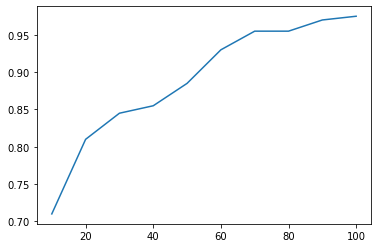

In [18]:
plt.plot(TN, TA)

In [19]:
TEST_ACCURACY = TEST(TEST_NUM=1000, TEST_ITERATION=10)

FIANL TEST ACCURACY : 1.000000


In [23]:
SEPARATION_LIST = [0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36 ,0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44]
TN = [100]

In [24]:
ACC = []
for sp in SEPARATION_LIST:
    TEST_ACCURACY = TEST(TEST_NUM=tn, SEPARATION=sp)
    ACC.append(TEST_ACCURACY)

FIANL TEST ACCURACY : 0.920000
FIANL TEST ACCURACY : 0.935000
FIANL TEST ACCURACY : 0.965000
FIANL TEST ACCURACY : 0.965000
FIANL TEST ACCURACY : 0.970000
FIANL TEST ACCURACY : 0.975000
FIANL TEST ACCURACY : 0.975000
FIANL TEST ACCURACY : 0.970000
FIANL TEST ACCURACY : 0.930000
FIANL TEST ACCURACY : 0.885000
FIANL TEST ACCURACY : 0.885000
FIANL TEST ACCURACY : 0.805000
FIANL TEST ACCURACY : 0.755000
FIANL TEST ACCURACY : 0.755000
FIANL TEST ACCURACY : 0.680000


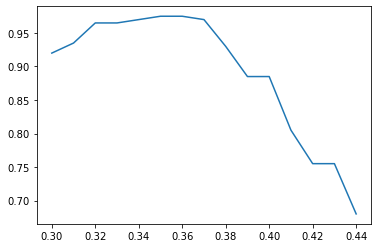

In [25]:
plt.plot(SEPARATION_LIST, ACC)